In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
import geopandas as gpd
%matplotlib inline

### Let's start by loading the Excel spreadsheets into pandas DataFrames. 

In [2]:
data_path = './data'
#act = pd.read_excel(f'{data_path}/ACT.xlsx')
#act_disag = pd.read_excel(f'{data_path}/ACT_DESAGREGADO.xlsx')
#adherence = pd.read_excel(f'{data_path}/Adherencia.xlsx')
familiar_records = pd.read_excel(f'{data_path}/Antecedentes_familiares.xlsx')
#pathological_records = pd.read_excel(f'{data_path}/Antecedentes_patologicos.xlsx')
#diagnostics_aids = pd.read_excel(f'{data_path}/Ayudas_diagnosticas.xlsx')
#biologics_asthma = pd.read_excel(f'{data_path}/Biologicos Asma.xlsx')
#life_quality = pd.read_excel(f'{data_path}/Calidad de vida relacioada en salud.xlsx')
#basic_info = pd.read_excel(f'{data_path}/Datos basicos.xlsx')
#dyspnea = pd.read_excel(f'{data_path}/Disnea.xlsx')
#ram_pharmacovigilance = pd.read_excel(f'{data_path}/Farmacovigilancia RAM.xlsx')
#habits = pd.read_excel(f'{data_path}/Habitos.xlsx')
#hospitalizations = pd.read_excel(f'{data_path}/Hospitalizaciones.xlsx')
#collecting_issues = pd.read_excel(f'{data_path}/Incosistencias en reclamacion.xlsx')
#medicines = pd.read_excel(f'{data_path}/Medicamentos.xlsx')
#height_weight = pd.read_excel(f'{data_path}/Mediciones de peso y talla.xlsx')
#emergencies = pd.read_excel(f'{data_path}/Urgencias.xlsx')
#vaccines = pd.read_excel(f'{data_path}/Vacunacion.xlsx')

### Family record

In [3]:
familiar_records.head()

,Id,EPS,FE_ALTA,FE_INICIO,FE_FIN,Diagnostico,CodDiagnostico,Parentesco
0,1998401,EPS/SURA,2012-07-09,2006-01-01,NaT,"ASMA, NO ESPECIFICADA",J459,MADRE
1,535255,EPS/SURA,2011-07-29,NaT,2011-07-29,"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...",E149,ABUELO
2,1004538,EPS/SURA,2012-01-17,2009-06-10,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE
3,788432,EPS/SURA,2012-01-06,2007-09-27,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE
4,788432,EPS/SURA,2012-01-06,2007-09-27,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE


In [4]:
familiar_records.columns = [col.lower() for col in familiar_records.columns]
familiar_records.rename(columns={
    'id': 'id_patient',
    'eps': 'health_provider',
    'fe_alta': 'creation_date',
    'fe_inicio': 'start_date',
    'fe_fin': 'end_date',
    'diagnostico': 'diagnosis',
    'coddiagnostico': 'diagnosis_code',
    'parentesco': 'relationship'
}, inplace=True)
familiar_records.head()

,id_patient,health_provider,creation_date,start_date,end_date,diagnosis,diagnosis_code,relationship
0,1998401,EPS/SURA,2012-07-09,2006-01-01,NaT,"ASMA, NO ESPECIFICADA",J459,MADRE
1,535255,EPS/SURA,2011-07-29,NaT,2011-07-29,"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...",E149,ABUELO
2,1004538,EPS/SURA,2012-01-17,2009-06-10,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE
3,788432,EPS/SURA,2012-01-06,2007-09-27,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE
4,788432,EPS/SURA,2012-01-06,2007-09-27,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE


In [5]:
familiar_records['id_patient'].unique().size

53

In [6]:
familiar_records['health_provider'] = familiar_records['health_provider'].astype('category')
familiar_records['diagnosis'] = familiar_records['diagnosis'].astype('category')
familiar_records['diagnosis_code'] = familiar_records['diagnosis_code'].astype('category')
familiar_records['relationship'] = familiar_records['relationship'].astype('category')

In [7]:
familiar_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_patient       104 non-null    int64         
 1   health_provider  104 non-null    category      
 2   creation_date    104 non-null    datetime64[ns]
 3   start_date       49 non-null     datetime64[ns]
 4   end_date         27 non-null     datetime64[ns]
 5   diagnosis        104 non-null    category      
 6   diagnosis_code   104 non-null    category      
 7   relationship     104 non-null    category      
dtypes: category(4), datetime64[ns](3), int64(1)
memory usage: 7.1 KB


In [8]:
familiar_records.describe(include='all')

,id_patient,health_provider,creation_date,start_date,end_date,diagnosis,diagnosis_code,relationship
count,1.040000e+02,104,104,49,27,104,104,104
unique,NaN,2,50,34,13,32,32,6
top,NaN,EPS/SURA,2011-09-13 00:00:00,2009-06-11 00:00:00,2011-09-13 00:00:00,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE
freq,NaN,99,6,4,6,30,30,35
first,NaN,NaN,2010-12-01 00:00:00,1950-01-01 00:00:00,2010-12-01 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2019-06-19 00:00:00,2019-03-15 00:00:00,2011-10-11 00:00:00,NaN,NaN,NaN
mean,1.299300e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.405538e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.294100e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.967585e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
familiar_records.drop_duplicates(inplace=True)

In [10]:
familiar_records.groupby('relationship').count().sort_values(by='id_patient', ascending=False)

,id_patient,health_provider,creation_date,start_date,end_date,diagnosis,diagnosis_code
relationship,,,,,,,
MADRE,35,35,35,20,8,35,35
PADRE,33,33,33,15,5,33,33
HERMANO(A),20,20,20,6,8,20,20
ABUELA,8,8,8,3,3,8,8
ABUELO,4,4,4,3,3,4,4
FAMILIAR CERCANO,4,4,4,2,0,4,4


In [11]:
familiar_records.groupby('diagnosis').count().sort_values(by='id_patient', ascending=False)

,id_patient,health_provider,creation_date,start_date,end_date,diagnosis_code,relationship
diagnosis,,,,,,,
HIPERTENSION ESENCIAL (PRIMARIA),30,30,30,17,5,30,30
"ASMA, NO ESPECIFICADA",26,26,26,15,4,26,26
"INFARTO AGUDO DEL MIOCARDIO, SIN OTRA ESPECIFICACION",5,5,5,2,4,5,5
DIABETES MELLITUS NO INSULINODEPENDIENTE SIN MENCION DE COMPLICACION,4,4,4,2,1,4,4
ASMA MIXTA,3,3,3,1,2,3,3
ASMA NO ALERGICA,3,3,3,0,1,3,3
"ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, NO ESPECIFICADA",3,3,3,0,2,3,3
DIABETES INSIPIDA,3,3,3,1,1,3,3
"CARDIOMIOPATIA, NO ESPECIFICADA",2,2,2,1,0,2,2


,id_patient,count
0,674247,7
1,1263349,5
2,1969148,4
3,1492864,4
4,788432,4


104


Text(0.5,1,'Number of family records per patient')

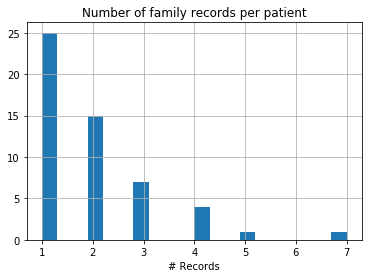

In [12]:
num_records_per_patient = familiar_records.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count')
display(num_records_per_patient.head())
print(sum(num_records_per_patient['count']))
num_records_per_patient.hist('count', bins=20)
plt.xlabel('# Records')
plt.title('Number of family records per patient')

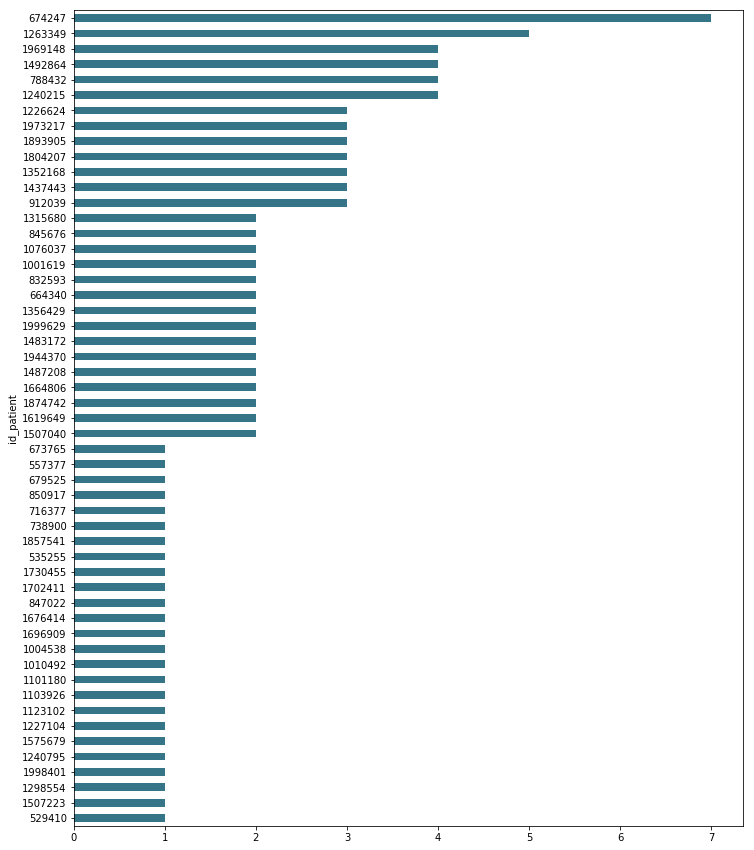

In [13]:
familiar_records.groupby('id_patient').count().sort_values(by='health_provider', ascending=True)['health_provider'].plot(kind='barh', figsize=(12,15), color='#367588')

Text(0.5,0,'Year')

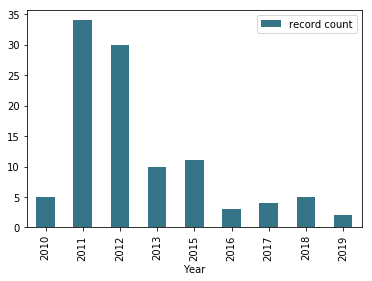

In [14]:
familiar_records['record_year'] = familiar_records['creation_date'].dt.year
ax = familiar_records[['record_year', 'diagnosis']].groupby('record_year').size().plot(kind='bar', color='#367588')
ax.legend(['record count'])
ax.set_xlabel('Year')

In [15]:
common_diagnosis = familiar_records[['id_patient', 'diagnosis']].groupby('diagnosis').size().sort_values(ascending=False).reset_index(name='count')
common_diagnosis.head(10)

,diagnosis,count
0,HIPERTENSION ESENCIAL (PRIMARIA),30
1,"ASMA, NO ESPECIFICADA",26
2,"INFARTO AGUDO DEL MIOCARDIO, SIN OTRA ESPECIFI...",5
3,DIABETES MELLITUS NO INSULINODEPENDIENTE SIN M...,4
4,DIABETES INSIPIDA,3
5,ASMA MIXTA,3
6,ASMA NO ALERGICA,3
7,"ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, NO ES...",3
8,"CARDIOMIOPATIA, NO ESPECIFICADA",2
9,"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...",2


Text(0.5,1,'Number of cases')

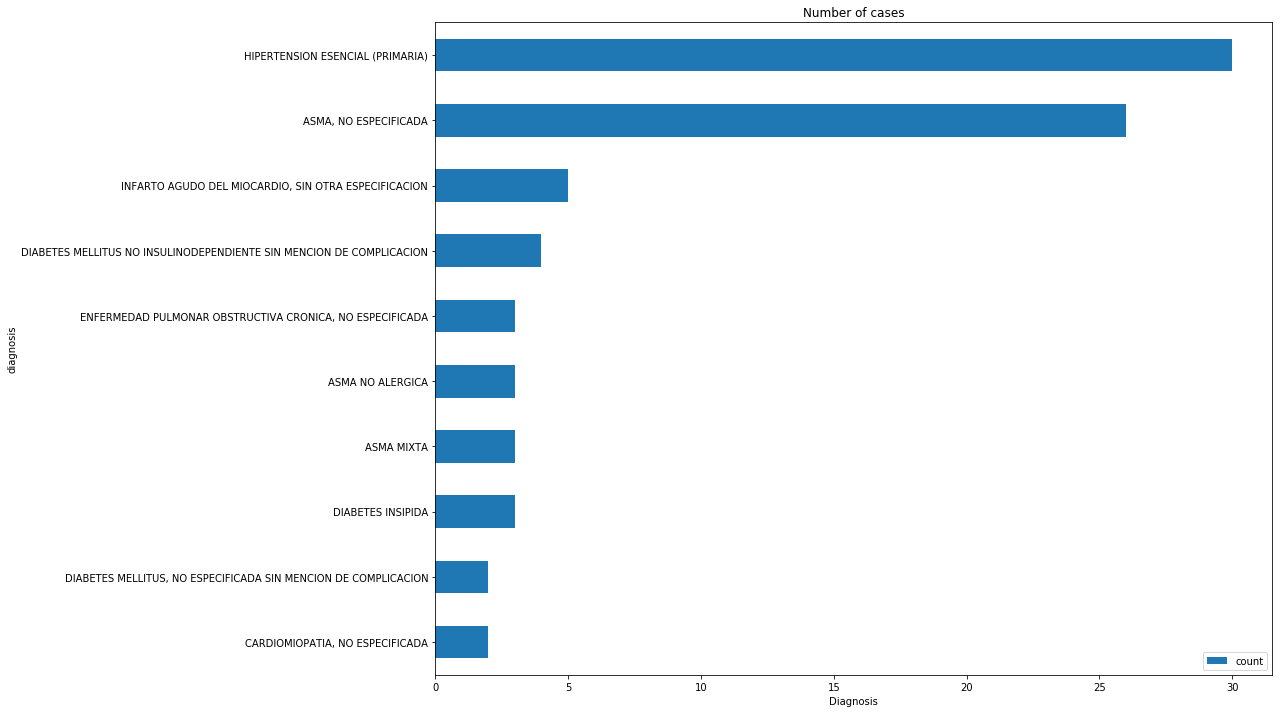

In [16]:
common_diagnosis.head(10).sort_values(by='count', ascending=True).plot(kind='barh', x='diagnosis', figsize=(15,12))
plt.xlabel('Diagnosis')
plt.title('Number of cases')

In [17]:
common_relative = familiar_records[['id_patient', 'relationship']].groupby('relationship').size().sort_values().reset_index(name='count')
common_relative.tail(10)

,relationship,count
0,ABUELO,4
1,FAMILIAR CERCANO,4
2,ABUELA,8
3,HERMANO(A),20
4,PADRE,33
5,MADRE,35


Text(0.5,1,'Number of cases')

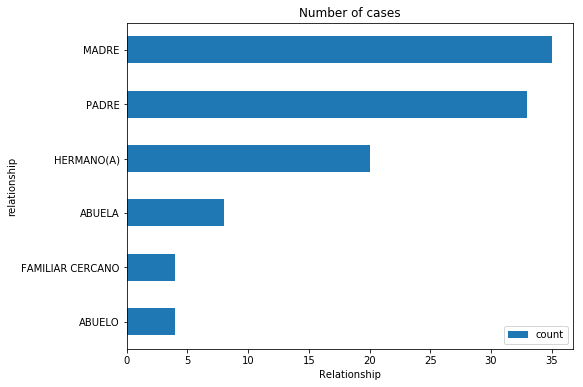

In [18]:
common_relative.plot(kind='barh', x='relationship', figsize=(8,6))
plt.xlabel('Relationship')
plt.title('Number of cases')

In [19]:
familiar_records[(~(familiar_records['end_date'].isna()))].shape

(27, 9)

In [20]:
familiar_records[(~familiar_records['start_date'].isna())].shape

(49, 9)

In [21]:
familiar_records[(~familiar_records['start_date'].isna()) & (~familiar_records['end_date'].isna())]

,id_patient,health_provider,creation_date,start_date,end_date,diagnosis,diagnosis_code,relationship,record_year
9,1437443,EPS/SURA,2010-12-01,2010-12-01,2010-12-01,"ASMA, NO ESPECIFICADA",J459,MADRE,2010
10,1437443,EPS/SURA,2010-12-01,2010-12-01,2010-12-01,"ASMA, NO ESPECIFICADA",J459,HERMANO(A),2010
11,1437443,EPS/SURA,2010-12-01,2010-12-01,2010-12-01,"INFARTO AGUDO DEL MIOCARDIO, SIN OTRA ESPECIFI...",I219,ABUELO,2010
14,1999629,EPS/SURA,2010-12-02,2010-12-02,2010-12-02,"RINITIS ALERGICA, NO ESPECIFICADA",J304,HERMANO(A),2010
15,1999629,EPS/SURA,2010-12-02,2010-12-02,2010-12-02,"ASMA, NO ESPECIFICADA",J459,ABUELO,2010
22,1101180,EPS/SURA,2011-03-16,2000-05-31,2011-03-16,"ASMA, NO ESPECIFICADA",J459,HERMANO(A),2011
69,1944370,EPS/SURA,2011-07-12,2011-07-12,2011-07-12,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE,2011


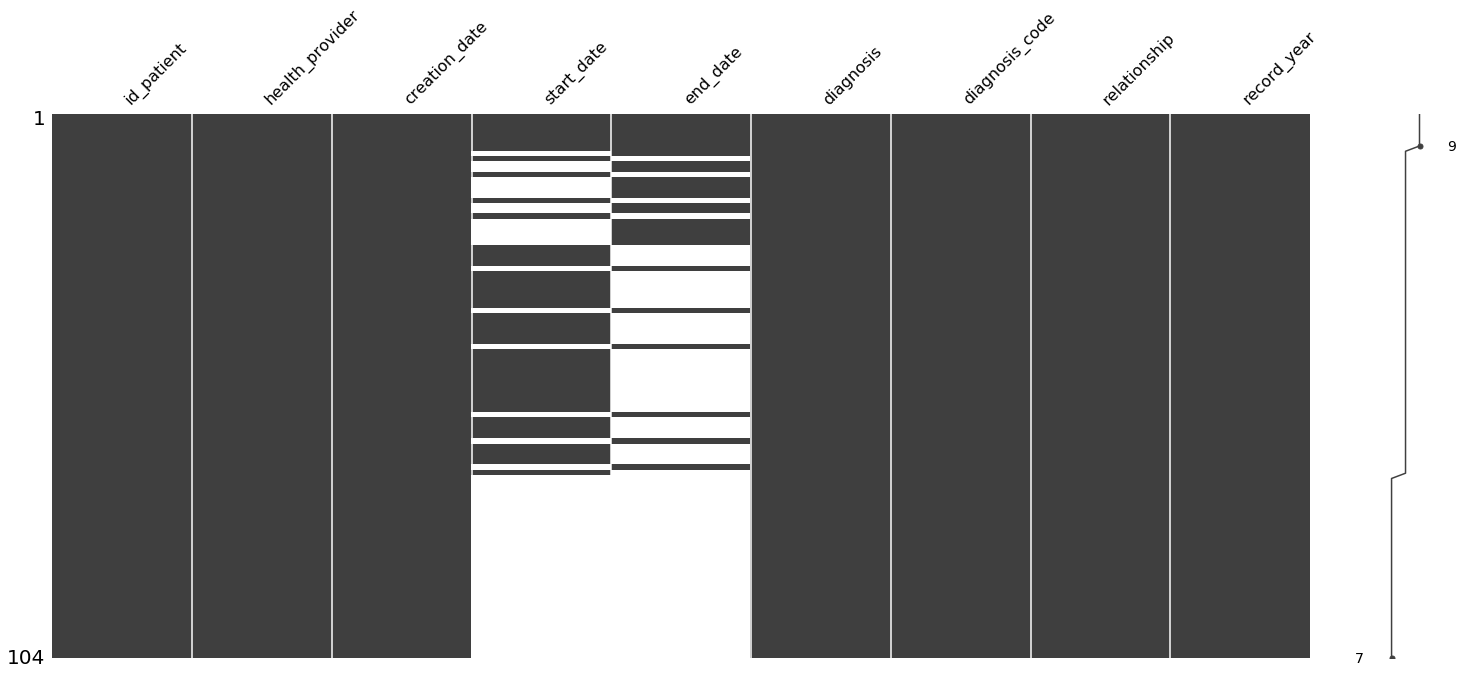

In [22]:
msno.matrix(msno.nullity_sort(familiar_records, sort='descending'))

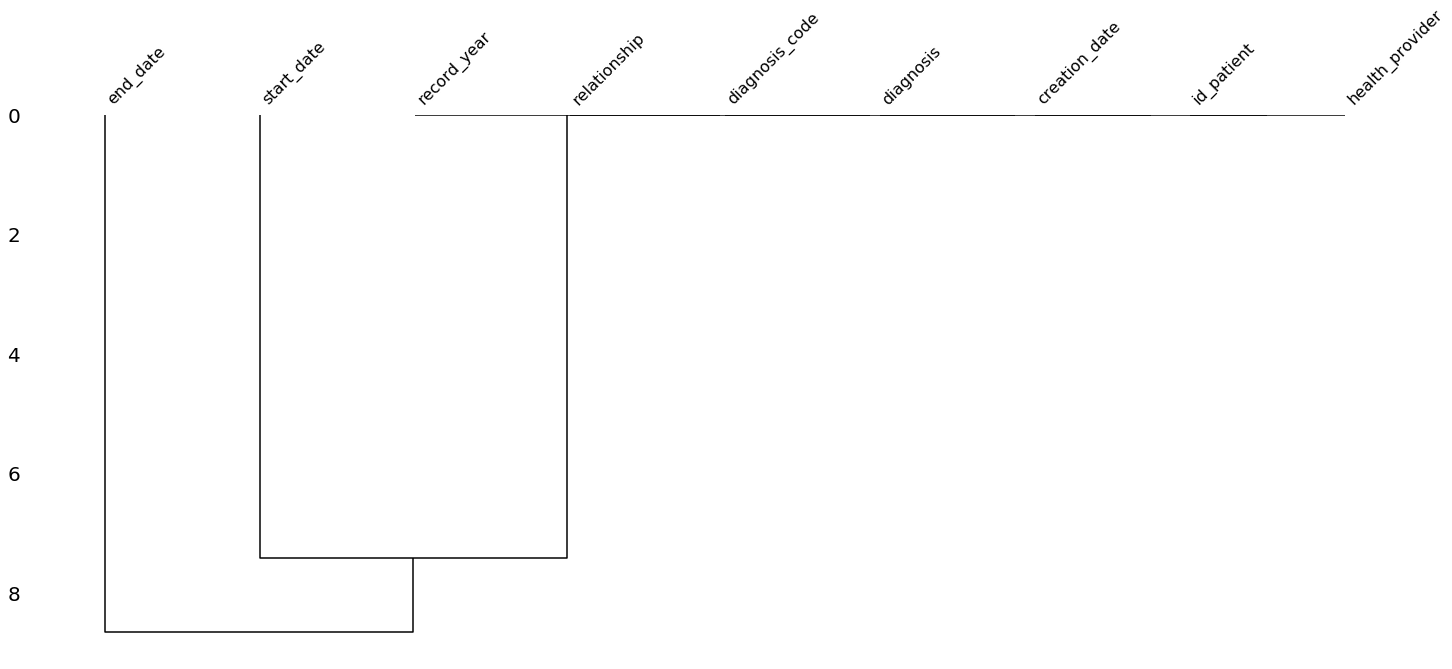

In [23]:
msno.dendrogram(familiar_records)

Both `start_date` (`fecha_inicio`) and `end_date` (`fecha_fin`) fields, have only been provided for 7 out of the 104 records. The `end_date` field has only been provided in 27 cases, while `start_date` only in 49 cases. Considering this we have opted for disposing of those columns:   

In [24]:
familiar_records.drop(columns=['start_date', 'end_date'], inplace=True)

### Cleansed dataset:

In [25]:
familiar_records.describe(include='all')

,id_patient,health_provider,creation_date,diagnosis,diagnosis_code,relationship,record_year
count,1.040000e+02,104,104,104,104,104,104.000000
unique,NaN,2,50,32,32,6,NaN
top,NaN,EPS/SURA,2011-09-13 00:00:00,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE,NaN
freq,NaN,99,6,30,30,35,NaN
first,NaN,NaN,2010-12-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,2019-06-19 00:00:00,NaN,NaN,NaN,NaN
mean,1.299300e+06,NaN,NaN,NaN,NaN,NaN,2012.721154
std,4.405538e+05,NaN,NaN,NaN,NaN,NaN,2.278889
min,5.294100e+05,NaN,NaN,NaN,NaN,NaN,2010.000000
25%,8.967585e+05,NaN,NaN,NaN,NaN,NaN,2011.000000


In [30]:
familiar_records_to_csv = familiar_records.copy()
familiar_records_to_csv = familiar_records_to_csv.set_index(familiar_records.index+1)
familiar_records_to_csv

,id_patient,health_provider,creation_date,diagnosis,diagnosis_code,relationship,record_year
1,1998401,EPS/SURA,2012-07-09,"ASMA, NO ESPECIFICADA",J459,MADRE,2012
2,535255,EPS/SURA,2011-07-29,"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...",E149,ABUELO,2011
3,1004538,EPS/SURA,2012-01-17,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE,2012
4,788432,EPS/SURA,2012-01-06,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE,2012
5,788432,EPS/SURA,2012-01-06,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE,2012
...,...,...,...,...,...,...,...
100,1893905,EPS/SURA,2017-11-22,"OSTEOPOROSIS POSTMENOPAUSICA, SIN FRACTURA PAT...",M810,MADRE,2017
101,1893905,EPS/SURA,2017-11-22,"ASMA, NO ESPECIFICADA",J459,HERMANO(A),2017
102,1010492,EPS/SURA,2017-12-18,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE,2017
103,1298554,EPS/SURA,2018-12-13,"ASMA, NO ESPECIFICADA",J459,PADRE,2018


In [31]:
familiar_records_to_csv.to_csv('./data/cleansed/antecedentes_familiares.csv', sep='|')